# Boosting

In this section, we will construct a boosting classifier with the `AdaBoost` algorithm and a boosting regressor with the `AdaBoost.R2` algorithm. These algorithms can use a variety of weak learners but we will use decision tree classifiers and regressors, constructed in {doc}`Chapter 5 </content/c5/concept>`.

In [1]:
## Import decision trees
import import_ipynb
import classification_tree as ct;

## Import numpy and visualization packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

importing Jupyter notebook from classification_tree.ipynb


## 1. Classification with AdaBoost

The following is a construction of the binary AdaBoost classifier introduced in the {doc}`concept section </content/c6/s1/boosting>`. Let's again use the {doc}`penguins </content/appendix/data>` dataset from `seaborn`, but rather than predicting the penguin's species (a multiclass problem), we'll predict whether the species is *Adelie* (a binary problem). The data is loaded and split into train vs. test with the hidden code cell below. 

In [2]:
## Load data
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace = True)
X = np.array(penguins.drop(columns = ['species', 'island']))
y = 1*np.array(penguins['species'] == 'Adelie')
y[y == 0] = -1

## Train-test split
np.random.seed(123)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = np.delete(X, test_idxs, 0)
y_train = np.delete(y, test_idxs, 0)
X_test = X[test_idxs]
y_test = y[test_idxs]


Recall that AdaBoost fits *weighted* weak learners. Let's start by defining the weighted loss functions introduced in the {doc}`concept section </content/c6/s1/boosting>`. The helper function `get_weighted_pmk()` calculates 

$$
\hat{p}_{mk} = \frac{\sumN w_n I(\bx_n \in \mathcal{N}_m)}{\sumN w_n}
$$

for each class $k$. The `gini_index()` and `cross_entropy()` functions then call this function and return the appropriate loss. 

In [3]:
## Loss Functions
def get_weighted_pmk(y, weights):
    ks = np.unique(y)
    weighted_pmk = [sum(weights[y == k]) for k in ks]      
    return(np.array(weighted_pmk)/sum(weights))

def gini_index(y, weights):
    weighted_pmk = get_weighted_pmk(y, weights)
    return np.sum( weighted_pmk*(1-weighted_pmk) )

def cross_entropy(y, weights):
    weighted_pmk = get_weighted_pmk(y, weights)    
    return -np.sum(weighted_pmk*np.log2(weighted_pmk))

def split_loss(child1, child2, weights1, weights2, loss = cross_entropy):
    return (len(child1)*loss(child1, weights1) + len(child2)*loss(child2, weights2))/(len(child1) + len(child2))


In order to incorporate observation weights, we have to make slight adjustments to the `DecisionTreeClassifier` class. In the class we {doc}`previously constructed </content/c5/s2/classification_tree>`, the data from parent nodes was split and funneled anonymously to one of two child nodes. This alone will not allow us to incorporate weights. Instead, we need to also track the ID of each observation so we can track its weight. This is done with the `DecisionTreeClassifier` class defined in the hidden cell below, which is mostly a reconstruction of the class defined in Chapter 5. 

In [4]:
## Helper Classes
class Node:
    
    def __init__(self, Xsub, ysub, observations, ID, depth = 0, parent_ID = None, leaf = True):
        self.Xsub = Xsub
        self.ysub = ysub
        self.observations = observations
        self.ID = ID
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf
        

class Splitter:
    
    def __init__(self):
        self.loss = np.inf
        self.no_split = True
        
    def _replace_split(self, loss, d, dtype = 'quant', t = None, L_values = None):
        self.loss = loss
        self.d = d
        self.dtype = dtype
        self.t = t
        self.L_values = L_values  
        self.no_split = False

        
## Main Class
class DecisionTreeClassifier:
    
    #############################
    ######## 1. TRAINING ########
    #############################
    
    ######### FIT ##########
    def fit(self, X, y, weights, loss_func = cross_entropy, max_depth = 100, min_size = 2, C = None):
        
        ## Add data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes]
        self.weights = weights
        
        ## Add model parameters
        self.loss_func = loss_func
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        ## Initialize nodes
        self.nodes_dict = {}
        self.current_ID = 0
        initial_node = Node(Xsub = X, ysub = y, observations = np.arange(self.N), ID = self.current_ID, parent_ID = None)
        self.nodes_dict[self.current_ID] = initial_node
        self.current_ID += 1
        
        # Build
        self._build()

    ###### BUILD TREE ######
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            ## Find eligible nodes for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~ct.all_rows_equal(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
            
            ## split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                ## Find split
                self._find_split(bud)
                
                ## Make split
                if not self.splitter.no_split:
                    self._make_split()
                
    ###### FIND SPLIT ######
    def _find_split(self, bud):
        
        ## Instantiate splitter
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        
        ## For each (eligible) predictor...
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            ## For each value...
            if dtype == 'quant':
                for t in np.unique(Xsub_d)[:-1]:
                    L_condition = Xsub_d <= t
                    ysub_L = bud.ysub[L_condition]
                    ysub_R = bud.ysub[~L_condition]
                    weights_L = self.weights[bud.observations][L_condition]
                    weights_R = self.weights[bud.observations][~L_condition]
                    loss = split_loss(ysub_L, ysub_R,
                                      weights_L, weights_R,
                                      loss = self.loss_func)
                    if loss < splitter.loss:
                        splitter._replace_split(loss, d, 'quant', t = t)
            else:
                for L_values in ct.possible_splits(np.unique(Xsub_d)):
                    L_condition = np.isin(Xsub_d, L_values)
                    ysub_L = bud.ysub[L_condition]
                    ysub_R = bud.ysub[~L_condition]
                    weights_L = self.weights[bud.observations][L_condition]
                    weights_R = self.weights[bud.observations][~L_condition]
                    loss = split_loss(ysub_L, ysub_R,
                                      weights_L, weights_R,
                                      loss = self.loss_func)
                    if loss < splitter.loss: 
                        splitter._replace_split(loss, d, 'cat', L_values = L_values)
                        
        ## Save splitter
        self.splitter = splitter
    
    ###### MAKE SPLIT ######
    def _make_split(self):
        
        ## Update parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        
        ## Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        child_observations_L = parent_node.observations[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]
        child_observations_R = parent_node.observations[~L_condition]
        
        ## Create child nodes
        child_node_L = Node(Xchild_L, ychild_L, child_observations_L,
                            ID = self.current_ID, depth = parent_node.depth + 1,
                            parent_ID = parent_node.ID)
        child_node_R = Node(Xchild_R, ychild_R, child_observations_R,
                            ID = self.current_ID + 1, depth = parent_node.depth + 1,
                            parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
                
            
    #############################
    ####### 2. PREDICTING #######
    #############################
    
    ###### LEAF MODES ######
    def _get_leaf_modes(self):
        self.leaf_modes = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                values, counts = np.unique(node.ysub, return_counts=True)
                self.leaf_modes[node_ID] = values[np.argmax(counts)]
    
    ####### PREDICT ########
    def predict(self, X_test):
        
        # Calculate leaf modes
        self._get_leaf_modes()
        
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_modes[node.ID])
        return np.array(yhat)
            


With the weighted decision tree constructed, we are ready to build our `AdaBoost` class. The class closely follows the algorithm introduced in the content section, which is copied below for convenience.
_____
**Discrete AdaBoost Algorithm**

Define the target variable to be $y_n \in \{-1, +1 \}$.

1. Initialize the weights with $w^1_n = \frac{1}{N}$ for $n = 1, 2, \dots, N$.

2. For $t = 1, \dots, T$,

   - Build weak learner $t$ using weights $\mathbf{w}^t$.

   - Calculate fitted values $f^t(\bx_n) \in \{-1, +1\}$ for $n = 1, 2, \dots, N$. Let $I^t_n$ equal 1 If $f^t(\bx_n) \neq y_n$ and 0 otherwise. That is, $I^t_n$ indicates whether learner $t$ misclassifies observation $n$.

   - Calculate the weighted error for learner $t$:
    
     $$
     \epsilon^t = \frac{\sumN w^t_n I^t_n}{\sumN w^t_n}.
     $$
   
   - Calculate the accuracy measure for learner $t$:

     $$
     \alpha^t = \log\left(\frac{1-\epsilon^t}{\epsilon^t}\right).
     $$
    
   - Update the weighting with 

     $$
     w^{t + 1}_n = w^t_n\exp(\alpha^tI^t_n),
     $$
    
     for $n = 1, 2, \dots, N$.

3. Calculate the overall fitted values with $\hat{y}_n = \text{sign} \left( \sum_{t = 1}^T \alpha^t f^t(\bx_n)\right)$.
_____

In [5]:
class AdaBoost:
    
    def fit(self, X_train, y_train, T, stub_depth = 1):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.T = T
        self.stub_depth = stub_depth
        
        ## Instantiate stuff
        self.weights = np.repeat(1/self.N, self.N)
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        
        for t in range(self.T):
            
            ## Calculate stuff
            self.T_t = DecisionTreeClassifier()
            self.T_t.fit(self.X_train, self.y_train, self.weights, max_depth = self.stub_depth)
            self.yhat_t = self.T_t.predict(self.X_train)
            self.epsilon_t = sum(self.weights*(self.yhat_t != self.y_train))/sum(self.weights)
            self.alpha_t = np.log( (1-self.epsilon_t)/self.epsilon_t )
            self.weights = np.array([w*(1-self.epsilon_t)/self.epsilon_t if self.yhat_t[i] != self.y_train[i]
                                    else w for i, w in enumerate(self.weights)])
            ## Append stuff
            self.trees.append(self.T_t)
            self.alphas.append(self.alpha_t)
            self.yhats[:,t] = self.yhat_t 
            
        self.yhat = np.sign(np.dot(self.yhats, self.alphas))
        
    def predict(self, X_test):
        yhats = np.zeros(len(X_test))
        for t, tree in enumerate(self.trees):
            yhats_tree = tree.predict(X_test)
            yhats += yhats_tree*self.alphas[t]
        return np.sign(yhats)
        
        
        

The `AdaBoost` model is finally fit below. To train the model, we supply the training data as well as `T`—the number of weak learners—and `stub_depth`—the depth for each tree (our weak learner). 

In [6]:
booster = AdaBoost()
booster.fit(X_train, y_train, T = 30, stub_depth = 3)
yhat = booster.predict(X_test)
np.mean(yhat == y_test)

0.9759036144578314

## 2. Regression with AdaBoost.R2

Next, let's implement *AdaBoost.R2*, a common boosting algorithm for regression tasks. We'll again use the {doc}`tips </content/appendix/data>` dataset from `seaborn`, loaded in the hidden code cell below.

In [7]:
## Import packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

## Load data
tips = sns.load_dataset('tips')
X = np.array(tips.drop(columns = 'tip'))
y = np.array(tips['tip'])

## Train-test split
np.random.seed(1)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = np.delete(X, test_idxs, 0)
y_train = np.delete(y, test_idxs, 0)
X_test = X[test_idxs]
y_test = y[test_idxs]

Since our boosting class will use regression trees for its weak learners, let's also import the regression tree we constructed in {doc}`Chapter 5 </content/c5/s2/regression_tree>`.

In [8]:
## Import decision trees
import import_ipynb
import regression_tree as rt;


importing Jupyter notebook from regression_tree.ipynb


Recall that the final fitted values in *AdaBoost.R2* are based on a weighted median. Let's first make a helper function to return the weighted median.  

In [9]:
def weighted_median(values, weights):
    
    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
    return values[median_weight]

We can then fit the `AdaBoostR2` class. This again follows the algorithm closely, which is again copied below for convenience.
____
**AdaBoost.R2 Algorithm**

1. Initialize the weights with $w^1_n = \frac{1}{N}$ for $n = 1, 2, \dots, N$.

2. For $t = 1, 2, \dots, T$ or while $\bar{L}^t$, as defined below, is less than or equal to 0.5,

   - Draw a sample of size $N$ from the training data with replacement and with probability $w^t_n$ for $n = 1, 2, \dots, N$. 
   - Fit weak learner $t$ to the resampled data and calculate the fitted values on the original dataset. Denote these fitted values with $f^t(\bx_{n})$ for $n = 1, 2, \dots, N$.
   - Calculate the observation error $L^t_{n}$ for $n = 1, 2, \dots, N$:
     
   $$
   \begin{aligned}
   D^t &= \underset{n}{\text{max}} \{ |y_{n} - f^t(\bx_{n})|  \} \\
   L^t_{n} &= \frac{|y_{n} - f^t(\bx_{n})|}{D^t}
   \end{aligned}
   $$

   - Calculate the model error $\bar{L}^t$:
     
     $$
     \bar{L}^t = \sum_{n = 1}^N  L^t_n w^t_n
     $$

     If $\bar{L}^t \geq 0.5$, end iteration and set $T$ equal to $t - 1$.

   - Let $\beta^t = \frac{\bar{L}^t}{1- \bar{L}^t}$. The lower $\beta^t$, the greater our confidence in the model. 

   - Let $Z^t = \sum_{n = 1}^N w^t_n (\beta^t)^{1 - L_n}$ and update the model weights with 
     
     $$
     w^{t + 1}_n = \frac{w^t_n (\beta^t)^{1 - L_n}}{Z^t},
     $$

     which increases the weight for observations with a greater error $L^t_n$.

3. Set the overall fitted value for observation $n$ equal to the weighted median of $f^t(\bx_n)$ for $t = 1, 2, \dots, T$ using weights $\log(1/\beta^t)$ for model $t$.
______

In [10]:
class AdaBoostR2:
    
    def fit(self, X_train, y_train, T = 100, stub_depth = 1, random_state = None):
        
        self.y_train = y_train
        self.X_train = X_train
        self.T = T
        self.stub_depth = stub_depth
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        np.random.seed(random_state)
        
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        for t in range(self.T):
            
            ## Draw sample, fit tree, get predictions
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            tree = rt.DecisionTreeRegressor()
            tree.fit(bootstrap_X, bootstrap_y, max_depth = stub_depth)
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:,t] = yhat
            
            ## Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t
            
            ## Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights*L_ts)
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            ## Calculate and record beta 
            beta_t = Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            
            ## Reweight
            Z_t = np.sum(self.weights*beta_t**(1-L_ts))
            self.weights *= beta_t**(1-L_ts)/Z_t
            
        ## Get median 
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])
        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X_test)
        return np.array([weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)]) 
        
        

Again, we fit our booster by providing training data in addition to `T`—the number of weak learners—and `stub_depth`—the depth for our regression tree weak learners.

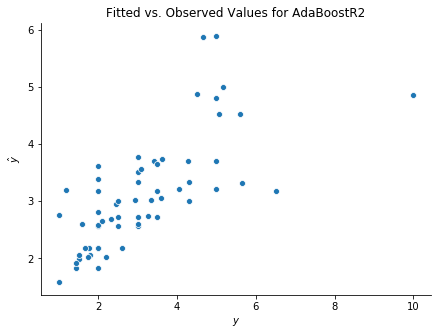

In [11]:
booster = AdaBoostR2()
booster.fit(X_train, y_train, T = 50, stub_depth = 4, random_state = 123)

fig, ax = plt.subplots(figsize = (7,5))
sns.scatterplot(y_test, booster.predict(X_test));
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = 'Fitted vs. Observed Values for AdaBoostR2')
sns.despine()